In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
os.chdir('drive/My Drive/Signature Verification/Dataset')
print(os.getcwd())

/content/drive/My Drive/Signature Verification/Dataset


**Data Preprocessing**

In [ ]:
def image_normalize(image):
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [ ]:
def image_modifier(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])

    image = image_normalize(image)
    return image, label

In [ ]:
def dataProcessor(image_file_path, label):
    image_file_path, filename = shuffle(image_file_path, label, random_state=0)

    train_image_path, train_label = image_path[:1300], label[:1300]
    validation_image_path, validation_label = image_path[1300:1500], label[1300:1500]
    test_image_path, test_label = image_path[1500:], label[1500:]

    trainloader = tf.data.Dataset.from_tensor_slices((train_image_path, train_label))
    trainloader = (trainloader.shuffle(32).map(image_modifier, num_parallel_calls=8).batch(8))

    validloader = tf.data.Dataset.from_tensor_slices((validation_image_path, validation_label))
    validloader = (validloader.shuffle(32).map(image_modifier, num_parallel_calls=8).batch(8))

    testloader = tf.data.Dataset.from_tensor_slices((test_image_path, test_label))
    testloader = (testloader.shuffle(32).map(image_modifier, num_parallel_calls=8).batch(8))

    return trainloader, validloader, testloader

**Loading Data from Google Drive**

In [ ]:
import re
label = []

image_path = sorted([filename for filename in os.listdir(os.getcwd()) if filename.endswith('.png')])

expression1 = '[0-9][0-9][0-9]'
expression2 = '[0-9][0-9]'

for filename in os.listdir(os.getcwd()):
    if filename.endswith('.png'):
        matches1 = re.findall(expression1, filename)
        matches2 = re.findall(expression2, filename)

        if int(matches1[0]) == int(matches2[3]):
            label.append(1)
        else:
            label.append(0)
    else:
        continue

label = np.array(sorted(label))
trainData, valData, testData = dataProcessor(image_path, label)

**Visualizing an image from the dataset**

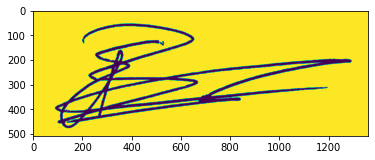

In [ ]:
sampleImage = plt.imread('NFI-00101001.png')
plt.imshow(sampleImage)

**Creating a Model** : Here I have used VGG-16 model, which I have programmed from scratch.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(AveragePooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(AveragePooling2D(2,2))

model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(AveragePooling2D(2,2))

model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(AveragePooling2D(2,2))

model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(AveragePooling2D(2,2))

model.add(Flatten())
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

adam = Adam(lr=1e-3)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

earlystopping = EarlyStopping(patience=3)
checkpoint_path = '/content/drive/My Drive/Signature Verification/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
callback = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True)

In [ ]:
model.fit(trainData, epochs=10, validation_data=valData, callbacks=[earlystopping, callback])

Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.6931 - binary_accuracy: 0.5000 WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Signature Verification/cp.ckpt/assets
163/163 [==============================] - 2601s 16s/step - loss: 0.6931 - binary_accuracy: 0.5000 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 2580s 16s/step - loss: 0.6931 - binary_accuracy: 0.5015 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 3/10
163/163 [=

**Testing the model & Finding accuracy**

In [ ]:
_, testAccuracy = model.evaluate(testData, batch_size=16)
print("Accuracy obtained on Validation Dataset : {:.2f} %".format(testAccuracy * 100))

8/8 [==============================] - 33s 4s/step - loss: 0.6931 - binary_accuracy: 0.5000
Accuracy obtained on Validation Dataset : 50.00 %
